# Result Overview

In this notebook, we create plots comparing the performance across the models.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

import data_support as sup
import scp.plots as pl
from scp.utils import *
import os

np.random.seed(0)

In [2]:
all_models = ["baseline", "conjunction", "selection", "hybrid", "downshift local", "5-nn", "protDP"]
color_palette = sns.color_palette('tab10', len(all_models))
color_map = { model: color_palette[i] for i, model in enumerate(all_models) }

First some functions for plotting.

In [21]:
def bar_comparison(results, y_label, title=None, ax=None, color_map=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3))
    
    models, values = zip(*results.items())
    cols = [color_map[name] if name in color_map else "blue" for name in models]

    ax.bar(models, values, color=cols, edgecolor="black", linewidth=1.5)
    ax.set_xticklabels(models, rotation=90, ha="center", fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)

    if title is not None:
        ax.set_title(title)
    
    ax.grid(True)
    ax.set_axisbelow(True)

def extract_key(results, key):
    return {name: value[key] for name, value in results.items() if key in value}

Let's combine the results from the different models into one dict.

In [4]:
models_to_use =  ["downshift local", "protDP", "downshift local", "5-nn", "baseline", "conjunction", "selection", "hybrid"]

In [5]:
results = { model_name : sup.load_dict_from_results(f"{model_name}.pkl") for model_name in models_to_use }

Let's create the plots.

## Combined plots

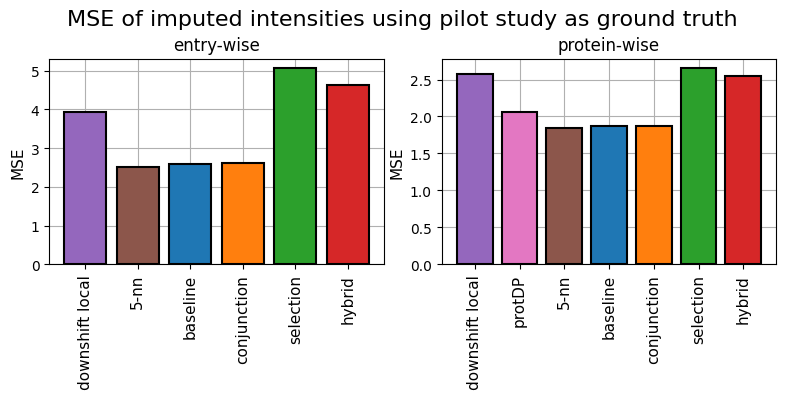

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

fig.suptitle("MSE of imputed intensities using pilot study as ground truth", fontsize=16)
fig.tight_layout()

res = extract_key(results, "pilot_model_mse")
bar_comparison(res, "MSE", "entry-wise", color_map=color_map, ax=axes[0])


res = extract_key(results, "pilot_model_protein_mse")
bar_comparison(res, "MSE", "protein-wise", color_map=color_map, ax=axes[1])

# save as svg
fig.savefig("figures/manns_pilot_model_comparison.svg", bbox_inches="tight")

## MAI

In [301]:
PATH = "../../results/manns_lab_data/mai/"

In [302]:
file_names = os.listdir(PATH)

raw_results = [sup.load_dict_from_results(file, results_dir=PATH) for file in file_names]

In [303]:
def reshape_results(raw_results):
    model_names = np.unique([block["model"] for block in raw_results])

    result = {}

    for name in model_names:
        result[name] = {}

        elements = [block for block in raw_results if block["model"] == name]
        for key in elements[0].keys():
            if key == "model": 
                continue

            result[name][key] = [block[key] for block in elements]


    for name in model_names:
        idx = np.argsort(result[name]["mnar_proportion"])
        for key in result[name].keys():
            result[name][key] = np.array(result[name][key])[idx]

    return result

In [304]:
results = reshape_results(raw_results)

In [305]:
results

{'5-nn': {'mnar_proportion': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
  'mse_test': array([0.19371632, 0.21306065, 0.24518517, 0.27316204, 0.30100531]),
  'mse_test_agg': array([0.00216474, 0.00720894, 0.02219592, 0.04451299, 0.07227504])},
 'baseline': {'mnar_proportion': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
  'mse_test': array([0.16840157, 0.18553539, 0.21929211, 0.24522961, 0.26708986]),
  'mse_test_agg': array([0.00182161, 0.00484472, 0.02149537, 0.04065194, 0.06318977])},
 'conjunction': {'mnar_proportion': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
  'mse_test': array([0.17092133, 0.19078475, 0.22204524, 0.24935654, 0.27556441]),
  'mse_test_agg': array([0.00139063, 0.00617856, 0.02135132, 0.04114568, 0.06857189])},
 'downshift local': {'mnar_proportion': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
  'mse_test': array([0.99556999, 0.92261395, 0.79301831, 0.66661617, 0.54588945]),
  'mse_test_agg': array([0.70147641, 0.61500437, 0.476239  , 0.36124001, 0.2652749 ])},
 'hybrid': {'mnar_prop

In [306]:
del results["downshift local"]
del results["protDP"]

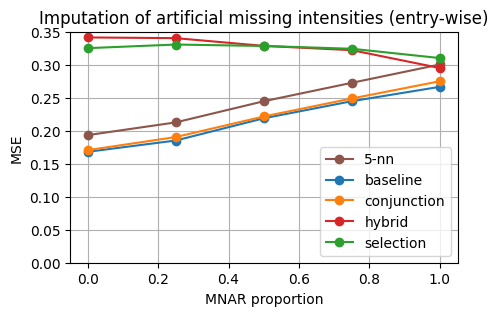

In [320]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

for model_name in results.keys():
    if "mse_test" not in results[model_name]:
        continue

    res = results[model_name]
    ax.plot(res["mnar_proportion"], res["mse_test"], label=model_name, marker="o", color=color_map[model_name])

ax.set_xlabel("MNAR proportion")
ax.set_ylabel("MSE")
ax.set_title("Imputation of artificial missing intensities (entry-wise)")
ax.set_ylim(bottom=0)
ax.legend()
ax.grid(True)

# save as svg
fig.savefig("figures/mai_entry.svg", bbox_inches="tight")

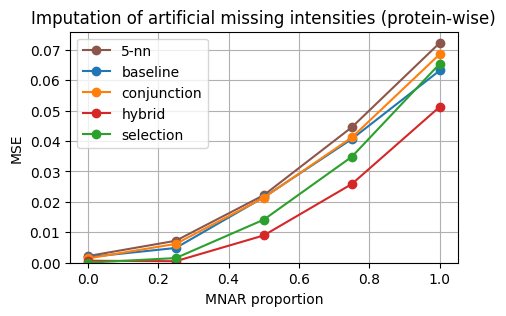

In [322]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

for model_name in results.keys():
    res = results[model_name]
    ax.plot(res["mnar_proportion"], res["mse_test_agg"], label=model_name, marker="o", color=color_map[model_name])

ax.set_xlabel("MNAR proportion")
ax.set_ylabel("MSE")
ax.set_title("Imputation of artificial missing intensities (protein-wise)")
ax.set_ylim(bottom=0)
ax.legend()
ax.grid(True)

# save as svg
fig.savefig("figures/mai_aggr.svg", bbox_inches="tight")